In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
pd.set_option('display.max_rows', 1000)

In [2]:
elections = pd.read_csv('data/Elections/all_elections.csv', parse_dates = ['Date Filed', 'Date Closed'])
elections.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30907 entries, 0 to 30906
Data columns (total 34 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Region                        30907 non-null  object        
 1   Case Number                   30907 non-null  object        
 2   Case Name                     30907 non-null  object        
 3   Status                        30907 non-null  object        
 4   Date Filed                    30907 non-null  datetime64[ns]
 5   Date Closed                   30498 non-null  datetime64[ns]
 6   Reason Closed                 30497 non-null  object        
 7   City                          30907 non-null  object        
 8   States & Territories          30907 non-null  object        
 9   Unit ID                       30907 non-null  object        
 10  Ballot Type                   30907 non-null  object        
 11  Tally Type                  

### GENERAL ANALYSIS

In [3]:
elections['Ballot Type'].value_counts()

Ballot Type
Single Labor Organization    28349
Two Labor Organizations       1553
Revised Single Labor Org       554
UD                             308
Three Labor Organizations      111
Revised Two Labor Orgs          32
Name: count, dtype: int64

In [4]:
# Restrict our attention to elections where only one union was on the ballot
single_elections = elections[elections['Ballot Type'] == 'Single Labor Organization']

In [6]:
# Restrict to representation elections
single_elections = single_elections[single_elections['Petition Type'] == 'RC']

In [7]:
# Set date closed as the index
single_elections.index = single_elections['Date Closed']

In [8]:
# Make it easier to read the win/loss outcome of the election
def get_outcome(reason):
    if reason == "Certific. of Representative":
        return "Win"
    elif reason == "Certification of Results":
        return "Loss"
    else:
        return ""
single_elections['Outcome'] = single_elections['Reason Closed'].apply(get_outcome)

In [10]:
# Make a column that counts the number of new union members in successful union votes 
single_elections['Number Unionized'] = single_elections['No of Eligible Voters']*single_elections['Outcome'].apply(lambda x: 1 if x == "Win" else 0)

In [11]:
# Drop duplicate case numbers (some of these are re-runs of the same election)
single_elections = single_elections.drop_duplicates(subset=['Case Number'], keep = 'last')

In [74]:
# Resample to count the number of new union members per month
number_unionized_by_month = single_elections['Number Unionized'].resample("M").sum()

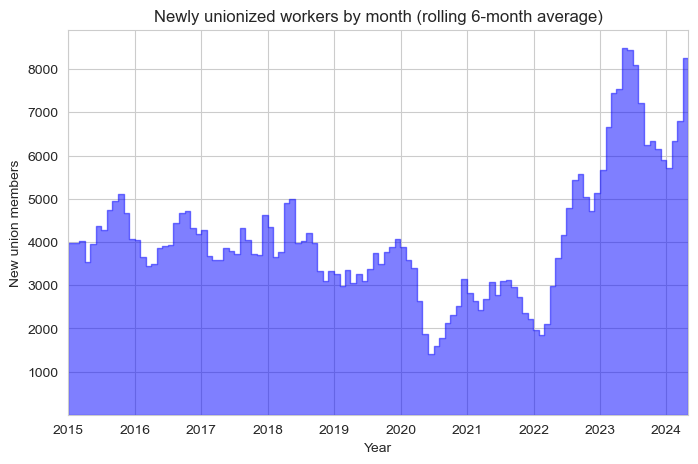

In [106]:
# Plot the result (rolling average smooths outliers a bit)
rolling_window = 6
rolling_average_number_by_month = number_unionized_by_month.loc["2014-07":"2024-04"].rolling(rolling_window).mean()
plt.figure(figsize = (8, 5))
plt.fill_between(rolling_average_number_by_month.index, rolling_average_number_by_month, color = 'blue', alpha=0.5, step='pre')
plt.xlabel("Year")
plt.ylabel("New union members")
plt.ylim(bottom = 0)
plt.yticks([(i+1)*1000 for i in range(8)])
plt.xlim(rolling_average_number_by_month.index[5], rolling_average_number_by_month.index[-1])
plt.title(f"Newly unionized workers by month (rolling {rolling_window}-month average)")
plt.show()

### STARBUCKS

In [18]:
starbucks_elections = elections[elections['Case Name'].astype(str).apply(lambda x: "starbuck" in x.lower()) | elections['Labor Union1'].astype(str).apply(lambda x: "starbuck" in x.lower())]

In [19]:
starbucks_elections.info()

<class 'pandas.core.frame.DataFrame'>
Index: 576 entries, 23713 to 28714
Data columns (total 34 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Region                        576 non-null    object        
 1   Case Number                   576 non-null    object        
 2   Case Name                     576 non-null    object        
 3   Status                        576 non-null    object        
 4   Date Filed                    576 non-null    datetime64[ns]
 5   Date Closed                   549 non-null    datetime64[ns]
 6   Reason Closed                 549 non-null    object        
 7   City                          576 non-null    object        
 8   States & Territories          576 non-null    object        
 9   Unit ID                       576 non-null    object        
 10  Ballot Type                   576 non-null    object        
 11  Tally Type                    5

In [20]:
starbucks_elections['Date Filed'].dt.year.value_counts()

Date Filed
2022    367
2023    136
2024     55
2021     18
Name: count, dtype: int64

In [21]:
starbucks_elections['Petition Type'].value_counts()

Petition Type
RC    570
RM      6
Name: count, dtype: int64

In [22]:
starbucks_elections['Reason Closed'].value_counts()

Reason Closed
Certific. of Representative    454
Certification of Results        93
Withdrawal Non-adjusted          2
Name: count, dtype: int64

In [23]:
starbucks_elections = starbucks_elections[['Petition Type', 'No of Eligible Voters', 'Void Ballots', 'Votes for Labor Union1', 'Votes Against', 'Total Ballots Counted', 'Turnout', 'Challenged Ballots', 'Challenges are Determinative', 'Union','Case Number', 'Case Name', 'Status', 'Reason Closed', 'Date Filed', 'Date Closed', 'City', 'States & Territories', 'Region']]

In [24]:
def get_outcome(reason):
    if reason == "Certific. of Representative":
        return "Win"
    elif reason == "Certification of Results":
        return "Loss"
    else:
        return ""

In [25]:
starbucks_elections['Outcome'] = starbucks_elections['Reason Closed'].apply(get_outcome)

In [26]:
starbucks_elections.index = starbucks_elections['Date Filed']

In [27]:
# Number of filings per month
filings_per_month = starbucks_elections[starbucks_elections['Petition Type'] == 'RC']['Petition Type'].apply(lambda x: 1 ).resample("M").sum()

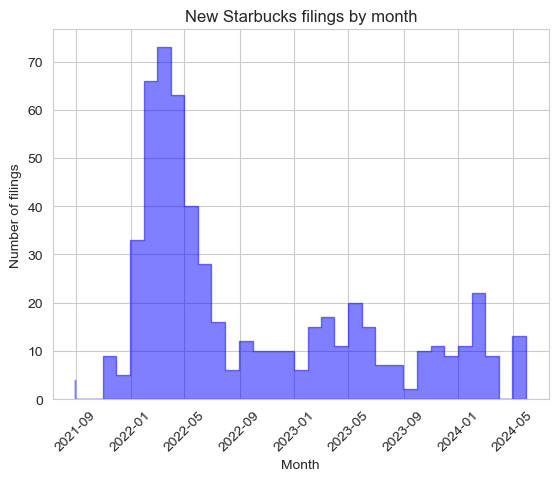

In [108]:
plt.fill_between(filings_per_month.index,filings_per_month, color = 'blue', alpha=0.5, step='pre')
plt.ylabel("Number of filings")
plt.xticks(rotation = 45)
plt.xlabel("Month")
plt.ylim(bottom = 0)
plt.title("New Starbucks filings by month")
plt.show()

### UE

In [37]:
ue_elections = elections[elections['Union'] == "UE"]

In [42]:
ue_elections.index = ue_elections['Date Closed']

In [43]:
ue_elections['Outcome'] = ue_elections['Reason Closed'].apply(get_outcome)

In [45]:
ue_elections.groupby(by = ue_elections['Date Closed'].dt.year)['Outcome'].value_counts()

Date Closed  Outcome
2007         Loss       1
             Win        1
2008         Win        9
             Loss       4
2010         Win        4
             Loss       2
2011         Win        1
             Loss       1
2012         Loss       8
             Win        4
2013         Loss       2
2014         Win        4
             Loss       1
2015         Win        7
                        3
2016         Win        5
2017         Win        5
             Loss       2
2018         Win        3
2019         Win        2
2020         Win        1
2021         Win        2
             Loss       1
2022         Win        5
2023         Win        8
2024         Win        1
Name: count, dtype: int64

In [46]:
ue_elections['Number Unionized'] = ue_elections['No of Eligible Voters']*ue_elections['Outcome'].apply(lambda x: 1 if x == "Win" else 0)

In [47]:
number_unionized_by_month = ue_elections['Number Unionized'].resample("M").sum()

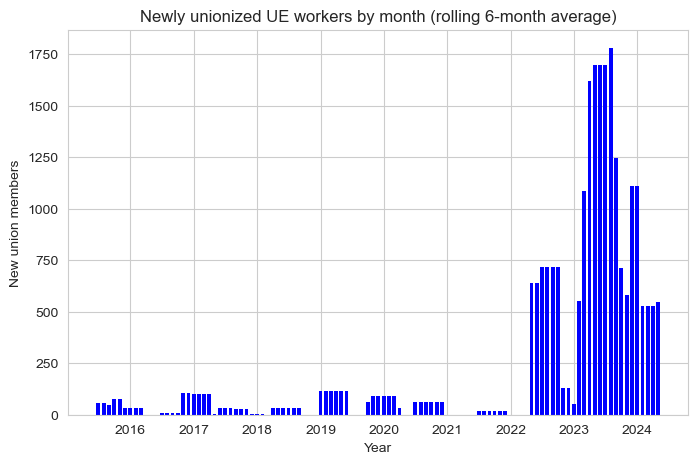

In [72]:
rolling_window = 6
rolling_average_number_by_month = number_unionized_by_month.loc["2015":"2024-04"].rolling(rolling_window).mean()
plt.figure(figsize = (8, 5))
plt.bar(rolling_average_number_by_month.index, rolling_average_number_by_month, width = 21.7, color = 'blue', edgecolor = "none")
plt.xlabel("Year")
plt.ylabel("New union members")
plt.title(f"Newly unionized UE workers by month (rolling {rolling_window}-month average)")
plt.show()

In [53]:
rolling_average_number_by_month

Date Closed
2010-01-31            NaN
2010-02-28            NaN
2010-03-31      54.000000
2010-04-30      64.666667
2010-05-31      10.666667
2010-06-30      14.666667
2010-07-31       4.000000
2010-08-31      29.666667
2010-09-30      25.666667
2010-10-31      25.666667
2010-11-30       0.000000
2010-12-31       0.000000
2011-01-31       0.000000
2011-02-28       0.000000
2011-03-31       0.000000
2011-04-30       0.000000
2011-05-31       0.000000
2011-06-30       0.000000
2011-07-31       0.000000
2011-08-31       0.000000
2011-09-30       0.000000
2011-10-31      81.000000
2011-11-30      81.000000
2011-12-31      81.000000
2012-01-31       0.000000
2012-02-29       0.000000
2012-03-31      11.000000
2012-04-30      11.000000
2012-05-31      15.666667
2012-06-30       4.666667
2012-07-31       4.666667
2012-08-31       0.000000
2012-09-30       0.000000
2012-10-31      12.000000
2012-11-30      12.000000
2012-12-31      12.000000
2013-01-31       0.000000
2013-02-28       0.000000
